In [1]:
import ee
import pandas as pd
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
%matplotlib inline
ee.Initialize()

from datetime import datetime
import time

# Extract ET from GLDAS through Earth Engine

In [9]:
ft = ee.Feature(ee.FeatureCollection("users/daviddralle/ca_et/central_valley").first())




In [12]:
# define the reducer to compute the mean over CA
ft = ee.Feature(ee.FeatureCollection("users/daviddralle/ca_et/central_valley").first())


def red(im):
    x = im.reduceRegion(reducer=ee.Reducer.mean(), geometry=ft.geometry(), scale=scl)
    f = ee.Feature(ee.Geometry.Point([0,0]), x)
    return f


evap = ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H').select('Evap_tavg').filterDate(ys+'-01-01', ys1+'-01-01')
# x = evap.map(red).getInfo()
ft = ft.getInfo()




In [3]:
# import CA outline
ft = ee.Feature(ee.FeatureCollection("users/daviddralle/ca_et/CA").first())

# define the reducer to compute the mean over CA
def red(im):
    x = im.reduceRegion(reducer=ee.Reducer.mean(), geometry=ft.geometry())
    f = ee.Feature(ee.Geometry.Point([0,0]), x)
    return f

# for each year, collect ET values
# must convert from kg/m^2/s to mm per 3 hour period
vals = []
dates = []
for year in range(2000, 2018):
    print(year)
    ys = str(year)
    ys1 = str(year+1)
    # ET from the current year
    evap = ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H').select('Evap_tavg').filterDate(ys+'-01-01', ys1+'-01-01')
    x = evap.map(red).getInfo()
    for feat in x['features']:
        vals.append(feat['properties']['Evap_tavg']*10800)
        d = feat['id']
        datestr = '%s-%s-%s %s'%(d[1:5], d[5:7], d[7:9], d[-4:])
        dates.append(pd.to_datetime(datestr))

df = pd.DataFrame(vals, index=dates, columns=['et-mm']).resample('M').sum()

yrs = []
vals = []
for yr in range(2002, 2018):
    yrs.append(yr)
    ys = str(yr-1)
    ys1 = str(yr)
    vals.append(df['et-mm'].loc[ys + '-07': ys1 + '-06' ].sum())
df_annual = pd.DataFrame(vals, index=yrs, columns=['et-mm-yr'])

df.to_csv('~/Desktop/et-monthly-ca.csv')
df_annual.to_csv('~/Desktop/et-annual-ca.csv')


et_regions = pd.read_csv('../data/wy_totals_regions.csv', index_col=0, parse_dates=True)
bess_ca = et_regions['California']
plt.plot(bess_ca.index.year, bess_ca.values, label='BESS water year ET')
plt.plot(df_annual.index, df_annual.values, label='GLDAS-2.1 water year ET')
plt.ylabel('ET [mm]')
plt.legend()
plt.savefig('/Users/daviddralle/Desktop/plt.pdf')

2000


KeyboardInterrupt: 

# Do extractions for GLDAS over central valley

In [8]:
ft = ee.Feature(ee.FeatureCollection("users/daviddralle/ca_et/central_valley").first())
evap = ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H').select('Evap_tavg').filterDate('2005-01-01', '2005-01-03')


In [9]:
# define the reducer to compute the mean over Central Valley
def red(im):
    x = im.reduceRegion(reducer=ee.Reducer.mean(), geometry=ft.geometry())
    f = ee.Feature(ee.Geometry.Point([0,0]), x)
    return f

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


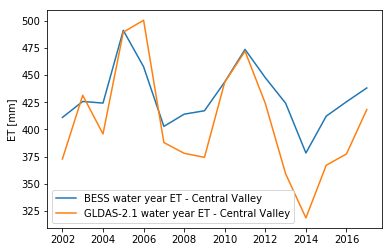

In [15]:
# ft = ee.Feature(ee.FeatureCollection("users/daviddralle/ca_et/central_valley").first())
# import CV outline
ft = ee.Feature(ee.FeatureCollection("users/daviddralle/ca_et/central_valley").first()).getInfo()
coords = ft['geometry']['coordinates'][2][0]
x = ee.Geometry.Polygon(coords=coords)
ft = ee.Feature(x)

# define the reducer to compute the mean over Central Valley
def red(im):
    x = im.reduceRegion(reducer=ee.Reducer.mean(), geometry=ft.geometry(), scale=100000)
    f = ee.Feature(ee.Geometry.Point([0,0]), x)
    return f

def stackCollection(collection):
    first = ee.Image(collection.first()).select([]);
    def appendBands(image, previous):
        image = image.rename([image.get('system:index')])
        return ee.Image(previous).addBands(image)
    return ee.Image(collection.iterate(appendBands, first))


# for each year, collect ET values
# must convert from kg/m^2/s to mm per 3 hour period
vals = []
dates = []
for year in range(2000, 2018):
    print(year)
    ys = str(year)
    ys1 = str(year+1)
    # ET from the current year
    evap = ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H').select('Evap_tavg').filterDate(ys+'-01-01', ys1+'-01-01')
    evap = stackCollection(evap) 
    x = evap.reduceRegion(reducer=ee.Reducer.mean(), geometry=ft.geometry(), scale=100000)
    f = ee.Feature(ee.Geometry.Point([0,0]), x).getInfo()

    for key in list(f['properties']):
        vals.append(f['properties'][key]*10800)
        d = key
        datestr = '%s-%s-%s %s'%(d[1:5], d[5:7], d[7:9], d[-4:])
        dates.append(pd.to_datetime(datestr))

df = pd.DataFrame(vals, index=dates, columns=['et-mm']).resample('M').sum()

yrs = []
vals = []
for yr in range(2002, 2018):
    yrs.append(yr)
    ys = str(yr-1)
    ys1 = str(yr)
    vals.append(df['et-mm'].loc[ys + '-07': ys1 + '-06' ].sum())
df_annual = pd.DataFrame(vals, index=yrs, columns=['et-mm-yr'])
df.to_csv('../data/monthly_gldas_centralvalley.csv')
df_annual.to_csv('../data/wytotal_gldas_centralvalley.csv')

et_regions = pd.read_csv('../data/wy_totals_regions.csv', index_col=0, parse_dates=True)
bess_cv = et_regions['Central Valley']
plt.plot(bess_cv.index.year, bess_cv.values, label='BESS water year ET - Central Valley')
plt.plot(df_annual.index, df_annual.values, label='GLDAS-2.1 water year ET - Central Valley')
plt.ylabel('ET [mm]')
plt.legend()
plt.savefig(home + '/Desktop/gldas_compare_cv.pdf')

# Extract values from annual modisSSEBv4

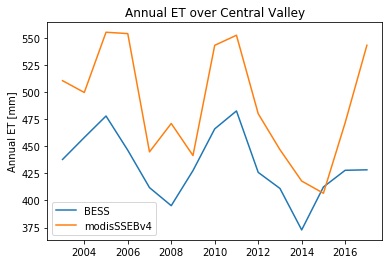

In [14]:
from pathlib import Path
home = str(Path.home())

ft = ee.Feature(ee.FeatureCollection("users/daviddralle/ca_et/central_valley").first())
usgs_eta = ee.Image('users/daviddralle/modisSSEBv4')
usgs_eta.getInfo()
x = usgs_eta.reduceRegion(ee.Reducer.mean(), ft.geometry()).getInfo()

vals = []
years = []
for item in list(x):
    if int(item[1:])==2018:
        continue
    years.append(int(item[1:]))
    vals.append(x[item])
years, vals = np.array(years), np.array(vals)
idx = np.argsort(years)
years, vals = years[idx], vals[idx]


# only compare over valid years from modisSSEB - 2003 to 2017 
bess_cv = pd.read_csv('../data/et_regions_2001-2017.csv', index_col=0, parse_dates=True)[['Central Valley']].resample('A').sum().loc['2003':'2018']
plt.plot(bess_cv.index.year, bess_cv.values, label='BESS')
plt.plot(years, vals, label = 'modisSSEBv4')
plt.legend()
plt.ylabel('Annual ET [mm]')
plt.title('Annual ET over Central Valley')
plt.savefig(home + '/Desktop/modisSSEBv4vsBESScentralvalley.pdf')
temp = pd.DataFrame(vals, index=years, columns=['modisSSEBv4'])
temp.to_csv(home + '/Desktop/modisSSEBv4centralvalley.csv')